In [1]:
!pip install scikit-learn
!pip install tensorflow

In [2]:
# prepare environment
root_dir = "/content"
runtime_dir = !pwd
if runtime_dir[0] != root_dir:
    raise Exception("Runtime folder does not match root folder.")
!rm -rf *

In [3]:
# Standard library
import os

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [4]:
!curl -u leprieto:fnnXN-KRkr9-dWJqy-x2GEE-E3P5N -o 00_dataset.zip "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/jupyter/05_croped_dataset.zip"
!unzip -q 00_dataset.zip
!mv 02_croped_dataset 00_dataset
!rm 00_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  154M  100  154M    0     0  21.1M      0  0:00:07  0:00:07 --:--:-- 27.3M


In [5]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 100
DATA_DIR = '00_dataset/dataset/casting_data/casting_data/train/'

train_dataset, val_dataset = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Binary classification
)

# val_dataset = image_dataset_from_directory(
    # DATA_DIR,
    # validation_split=0.2,
    # subset="validation",
    # seed=42,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode='binary'
# )

# Ver pritn classes and distribution
class_names = train_dataset.class_names
print(f"Classes: {class_names}")
print(f"Training samples: {train_dataset.cardinality().numpy() * BATCH_SIZE}")
print(f"Validation samples: {val_dataset.cardinality().numpy() * BATCH_SIZE}")

# augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    # layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

# normalization.
preprocess = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

model = models.Sequential([
  layers.Input(shape=IMG_SIZE + (3,)),  # +3 channels
    data_augmentation,
    preprocess,

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# weights for unbalanced dataset
labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels.flatten()
)
class_weights = {i: w for i, w in enumerate(class_weights)}

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model.weights.h5",
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=True),
    # tf.keras.callbacks.ModelCheckpoint('01_best_model.keras', save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

model.load_weights("model.weights.h5")
loss, accuracy= model.evaluate(val_dataset)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")

train_loss = history.history['loss']
val_loss = history.history['val_loss']
print(f"Loss {train_loss}")
print(f"Validation Loss: {val_loss}")

Found 6569 files belonging to 2 classes.
Using 5256 files for training.
Using 1313 files for validation.
Classes: ['def_front', 'ok_front']
Training samples: 5280
Validation samples: 1344
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.6145 - loss: 1.1158 - val_accuracy: 0.8088 - val_loss: 0.3868
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.8056 - loss: 0.4031 - val_accuracy: 0.8995 - val_loss: 0.2348
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.8933 - loss: 0.2442 - val_accuracy: 0.8926 - val_loss: 0.2036
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.9182 - loss: 0.1959 - val_accuracy: 0.9307 - val_loss: 0.1461
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9270 - loss: 0.1756 - val_accuracy: 0.9566 - val_loss: 0.1154
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9337 - loss: 0.1543 - val_accuracy: 0.9566 - val_loss: 0.1178
Epoch 7/100
165/165 ━━━━

Found 715 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━

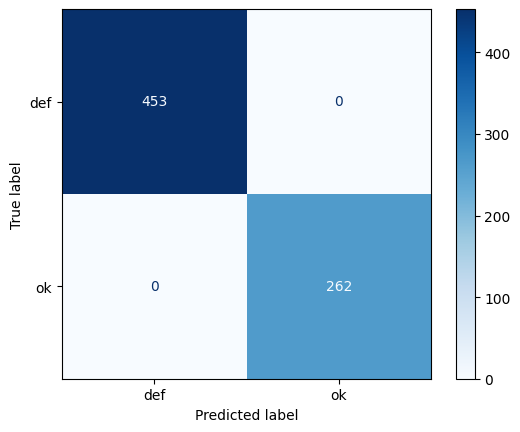

              precision    recall  f1-score   support

         def       1.00      1.00      1.00       453
          ok       1.00      1.00      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



In [6]:
test_dataset = image_dataset_from_directory(
    '00_dataset/dataset/casting_data/casting_data/test/',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=1,
    label_mode='binary'  # Binary classification
)

# Get true labels and model predictions
true_labels = []
predictions = []
# Iterate through test dataset
# n = 0
for images, labels in test_dataset:
    # print(labels[0])
    true_labels.extend(labels.numpy())
    batch_pred = model.predict(images)
    predictions.extend((batch_pred > 0.5).astype(int).flatten())  # Convert probabilities to class labels
    # n = n+1
    # if n == 100:
    #   break;

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=['def', 'ok'])
report = classification_report(true_labels, predictions, target_names=['def', 'ok'])
cm_display.plot(cmap=plt.cm.Blues)
plt.savefig("confusion_matrix.svg")
plt.show()
print(report)

In [7]:
!zip -r *

  adding: confusion_matrix.svg (deflated 74%)
  adding: model.weights.h5 (deflated 27%)


In [ ]:
!curl -u leprieto:fnnXN-KRkr9-dWJqy-x2GEE-E3P5N -o 01_best_model.keras "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/jupyter/07_classification_model_croped_v2.keras"

Found 715 files belonging to 2 classes.


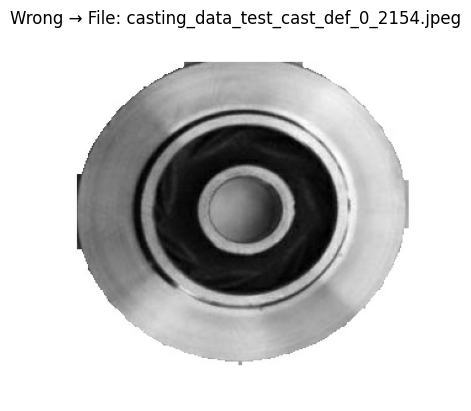

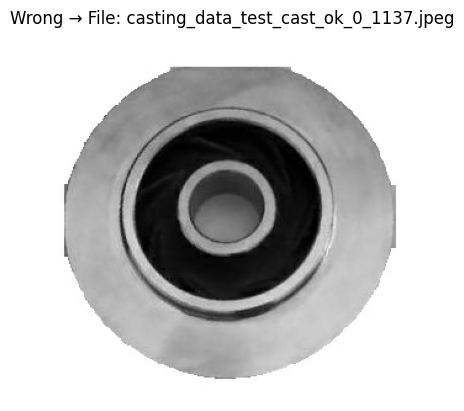

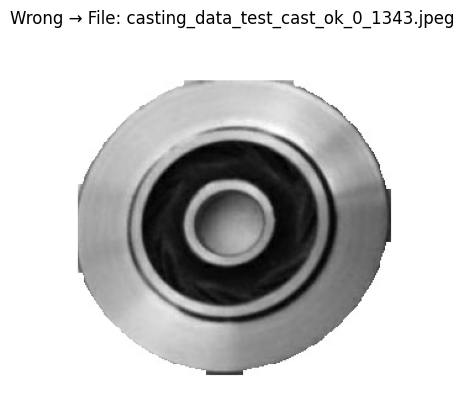

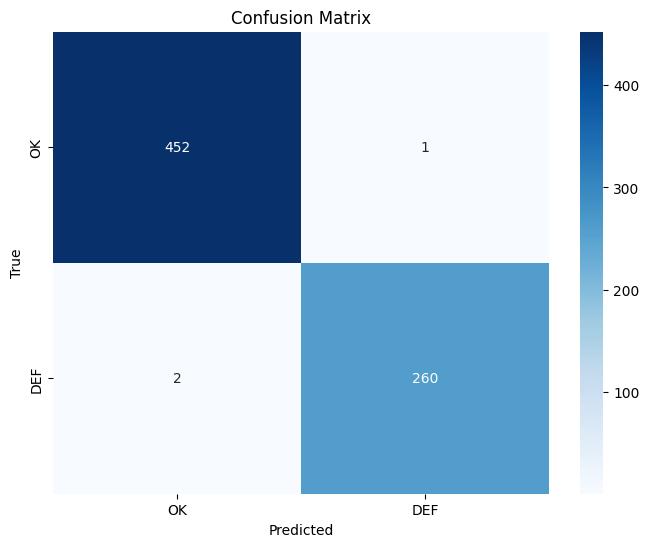

Accuracy: 1.00
Precision: 1.00
Recall: 0.99
F1 Score: 0.99


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

IMG_SIZE = (300, 300)
BATCH_SIZE = 32
TEST_DIR = '00_dataset/dataset/casting_data/casting_data/test/'

# 1. Load file paths in sorted order
file_paths_ds = tf.data.Dataset.list_files(str(TEST_DIR + '*/**'), shuffle=False)
file_paths = sorted([f.numpy().decode() for f in file_paths_ds])  # Make filenames match the dataset order

# 2. Load the dataset (ensure shuffle=False)
test_dataset = image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=1,
    label_mode='binary',
    shuffle=False
)

# 3. Predict and compare
# model = tf.keras.models.load_model("01_best_model.keras", compile=True, safe_mode=True)

true_labels = []
predictions = []
wrong_images = []
wrong_paths = []

for (img_batch, label_batch), path in zip(test_dataset, file_paths):
    pred = (model(img_batch, training=False) > 0.5).numpy().astype(int).flatten()[0]
    true = label_batch.numpy()[0]
    predictions.append(pred)
    true_labels.append(true)

    if pred != true:
        wrong_images.append(img_batch.numpy()[0])
        wrong_paths.append(path)

# 4. Visualize some misclassifications
for i in range(min(5, len(wrong_images))):
    plt.imshow(wrong_images[i].astype("uint8"))
    plt.title(f"Wrong → File: {os.path.basename(wrong_paths[i])}")
    plt.axis("off")
    plt.show()

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['OK', 'DEF'],
            yticklabels=['OK', 'DEF'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# # Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,127,621 (919.83 MB)

 Trainable params: 80,375,873 (306.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,751,748 (613.22 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Model prediction: [[0.28667533]]


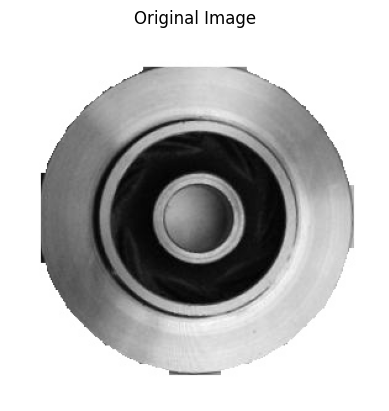

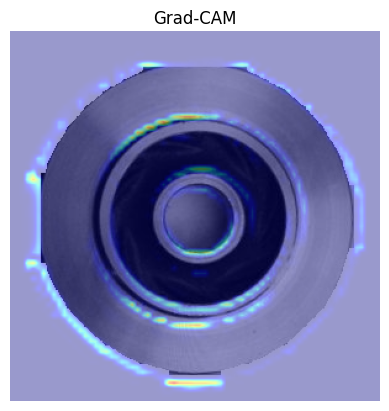

In [ ]:
import cv2
import matplotlib.cm as cm

def get_img_array(img_path, size=(300, 300)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # array = array / 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output,
         model.get_layer("dense_1").output]
    )

    with tf.GradientTape() as tape:
        # Run the model and get the desired layer outputs.
        last_conv_layer_output, preds = grad_model(img_array)
        # Explicitly tell the tape to watch the last conv layer output
        tape.watch(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the top predicted class with respect to
    # the output feature map of the last conv layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)
    if grads is None:
        raise ValueError("The computed gradients are None. Check if your model is properly connected.")

    # Pool the gradients over the spatial dimensions.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the output of the conv layer for the input image.
    last_conv_layer_output = last_conv_layer_output[0]
    # Compute the dot product between each channel in the feature map
    # and the corresponding pooled gradient values.
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap for visualization.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def overlay_heatmap(img_path, heatmap, alpha=0.4):
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    colormap = cm.jet(heatmap)
    colormap = np.uint8(255 * colormap[..., :3])
    overlayed_img = cv2.addWeighted(original_img, 1 - alpha, colormap, alpha, 0)
    return original_img, overlayed_img



img_path = "/content/00_dataset/dataset/casting_data/casting_data/test/ok_front/casting_data_test_cast_ok_0_10.jpeg"
img_array = get_img_array(img_path)

model.summary()

# 1) Force a forward pass so the model is 'called'
preds = model.predict(img_array)
print("Model prediction:", preds)

# 2) Now build Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, "conv2d_2")
original_img, overlayed_img = overlay_heatmap(img_path, heatmap)

plt.figure()
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.figure()
plt.title("Grad-CAM")
plt.imshow(overlayed_img)
plt.axis("off")
plt.show()

[1. 0. 0. ... 0. 0. 1.]


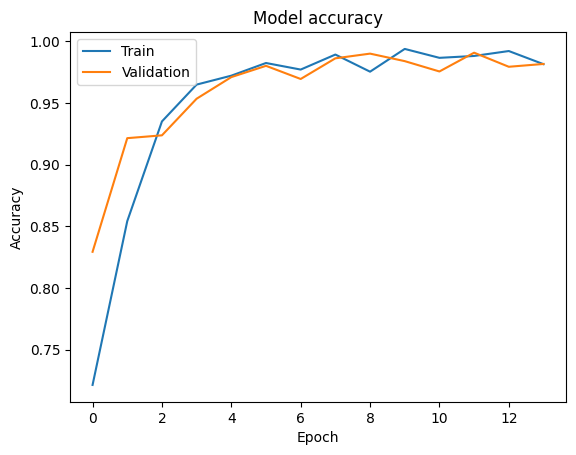

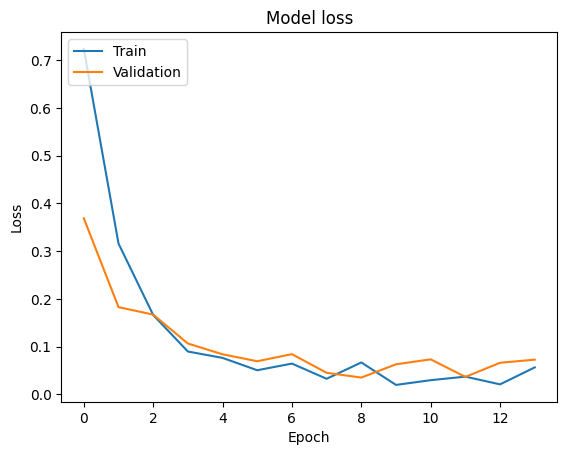

In [ ]:
# Plot training vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load your model
import numpy as np

model = tf.keras.models.load_model("01_best_model.keras", compile=True, safe_mode=True)
model.export("01_best_model_savedmodel")
model = tf.keras.models.load_model("01_best_model_savedmodel")



Saved artifact at '01_best_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136692034620688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034623568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034624144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034624720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034623952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034625488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034622608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034626448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034625680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136692034627600: TensorSpec(shape=(), dtype=tf.resource, name=None)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,127,621 (919.83 MB)

 Trainable params: 80,375,873 (306.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,751,748 (613.22 MB)

NameError: name 'make_gradcam_heatmap' is not defined

In [ ]:
!curl -u leprieto:fnnXN-KRkr9-dWJqy-x2GEE-E3P5N -T 01_best_model.keras "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/jupyter/07_classification_model_croped_v2.keras"

Se han truncado las últimas 5000 líneas del flujo de salida.
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemental data (23):
* TLSv1.2 (OUT), TLS header, Supplemen

Found 715 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


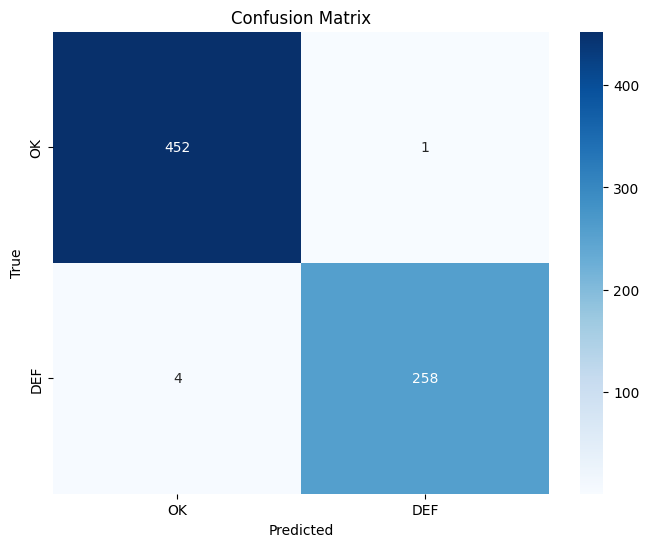

Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


In [ ]:
# # def predict_image(image_path):
# #     img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
# #     img_array = tf.keras.utils.img_to_array(img)
# #     img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# #     prediction = model.predict(img_array)
# #     return class_names[0] if prediction[0] < 0.5 else class_names[1]

# test_dataset = image_dataset_from_directory(
#     '00_dataset/dataset/casting_data/casting_data/test/',
#     seed=22,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode='binary'  # Binary classification
# )


# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# true_labels = []
# predictions = []

# model2 = keras.saving.load_model("01_best_model.keras", custom_objects=None, compile=True, safe_mode=True)

# for images, labels in test_dataset:
#     true_labels.extend(labels.numpy())
#     batch_pred = model2.predict(images)
#     predictions.extend((batch_pred > 0.5).astype(int).flatten())

# true_labels = np.array(true_labels)
# predictions = np.array(predictions)

# # confusion matrix
# cm = confusion_matrix(true_labels, predictions)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['OK', 'DEF'],
#             yticklabels=['OK', 'DEF'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # # Calculate additional metrics
# tn, fp, fn, tp = cm.ravel()
# accuracy = (tp + tn) / (tp + tn + fp + fn)
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)

# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

In [ ]:
# # def predict_image(image_path):
# #     img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
# #     img_array = tf.keras.utils.img_to_array(img)
# #     img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# #     prediction = model.predict(img_array)
# #     return class_names[0] if prediction[0] < 0.5 else class_names[1]





# # test_dataset = image_dataset_from_directory(
# #     '00_dataset/dataset/casting_data/casting_data/test/',
# #     seed=42,
# #     image_size=IMG_SIZE,
# #     batch_size=BATCH_SIZE,
# #     label_mode='binary'  # Binary classification
# # )






# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import cv2

# true_labels = []
# predictions = []
# # file_name = []

# wrong_predictions = []

# model2 = keras.saving.load_model("01_best_model.keras", custom_objects=None, compile=True, safe_mode=True)

# for root, dirs, files in os.walk("00_dataset/dataset/casting_data/casting_data/test/"):
#   folder_name = os.path.basename(root)
#   print("Inspecting root:", root)
#   print("Folder name:", folder_name)
#   print("Files:", files[:3])  # First 3 files
#   if folder_name == "def_front":
#     true_label = 0
#   elif folder_name == "ok_front":
#     true_label = 1
#   else:
#     continue  # skip unknown folders
#   for file in files:
#     if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
#       continue  # skip non-images
#     img = tf.keras.utils.load_img(os.path.join(root, file), target_size=IMG_SIZE)
#     img_array = tf.keras.utils.img_to_array(img)
#     # img_array = img_array / 255.0  # Match model input scale
#     img_array = np.expand_dims(img_array, axis=0)
#     # image = cv2.imread(str(os.path.join(root, file)))
#     # image = np.expand_dims(image, axis=0)
#     pred = (model2.predict(img_array, verbose=False) > 0.5).astype(int).flatten()
#     predictions.append(pred[0])
#     true_labels.append(true_label)
#     if pred[0] != true_label:
#       print(f"MISCLASSIFIED → File: {file}, Folder: {folder_name}, Pred: {pred[0]}, True: {true_label}")


# #     if pred != true_label:
# #       fig, ax = plt.subplots()
# #       ax.set_title(f"File: {file}, Predicted: {pred}, True: {true_label}")
# #       ax.imshow(image[0])
# #       wrong_predictions.append(fig)

# # for fig in wrong_predictions:
# #   plt.show()

# # for i in range(len(true_labels)):
# #   if predictions[i] != true_labels[i]:
# #     plt.title(f"File: {file_name[i]}, Predicted: {predictions[i]}, True: {true_labels[i]}")



# # for images, labels in test_dataset:
# #     true_labels.extend(labels.numpy())
# #     batch_pred = model2.predict(images)
# #     predictions.extend((batch_pred > 0.5).astype(int).flatten())
#     # for image in images:
#       # img = tf.keras.utils.array_to_img(image)
#       # plt.imshow(img)
#     # for i in range(len(images)):
#       # if predictions[i] != true_labels[i]:
#       #   plt.imshow(images[i].numpy().astype("uint8"))
#       #   plt.show()
#         # plt.title(f"Predicted: {class_names[predictions[i]]}, True: {class_names[true_labels[i]]}")

# # for i in range(len(true_labels)):
# #   if predictions[i] != true_labels[i]:
# #     # plt.imshow(imgs[i].numpy().astype("uint8"))
# #     plt.title(f"Predicted: {predictions[i]}, True: {true_labels[i]}, Index: {i}")
# #     plt.show()
# #     # print(f"Predicted: {predictions[i]}, True: {true_labels[i]}")

# true_labels = np.array(true_labels)
# predictions = np.array(predictions)

# # confusion matrix
# cm = confusion_matrix(true_labels, predictions)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['OK', 'DEF'],
#             yticklabels=['OK', 'DEF'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # # Calculate additional metrics
# tn, fp, fn, tp = cm.ravel()
# accuracy = (tp + tn) / (tp + tn + fp + fn)
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)

# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")